
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Deep Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Fall 2024<br>
<font color=3C99D size=5>
Project <br>
<font color=696880 size=4>
<!-- <br> -->


____

<font color=2565AE size=6>
Parsa Hatami <br>
<font color=2565AE size=6>
400100962 <br>

____

In [2]:
!pip install kaggle

In [4]:
import pandas as pd
import kagglehub
from torch.utils.data import Dataset, DataLoader
import torch
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Optional

## Importing data from Kaggle dataset to colab

In [5]:
  # Download dataset using kagglehub
  path = kagglehub.dataset_download("ayushspai/sportsmot")
  print("Path to dataset files:", path)

  !cp -r /root/.cache/kagglehub/datasets/ayushspai/sportsmot/versions/1/sportsmot_publish/splits_txt /content/drive/MyDrive/Project/



100%|██████████| 33.5G/33.5G [08:26<00:00, 71.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayushspai/sportsmot/versions/1
cp: cannot create directory '/content/drive/MyDrive/Project/': No such file or directory


### See the folders inside each sequence

In [6]:
!ls /root/.cache/kagglehub/datasets/ayushspai/sportsmot/versions/1/sportsmot_publish/dataset/train/v_1LwtoLPw2TU_c006

gt  img1  seqinfo.ini


In [9]:
sequence_path = "/root/.cache/kagglehub/datasets/ayushspai/sportsmot/versions/1/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c600/img1"
output_video_path = "/content/v_G-vNjfx1GGc_c600_video.mp4"

frame_files = sorted(os.listdir(sequence_path))

first_frame_path = os.path.join(sequence_path, frame_files[0])
first_frame = cv2.imread(first_frame_path)

height, width, _ = first_frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 25.0
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

for frame_file in frame_files:
    frame_path = os.path.join(sequence_path, frame_file)
    frame = cv2.imread(frame_path)

    if frame is not None:
        out.write(frame)

out.release()

print(f"✅ Video created successfully! Saved at: {output_video_path}")


✅ Video created successfully! Saved at: /content/v_G-vNjfx1GGc_c600_video.mp4


Video saved at: /content/SOT_CSRT_output.mp4
Heatmap saved at: /content/heatmap.png
Success Score: 0.6661
Precision Score (at 20px error): 82.80%
Tracking Speed: 28.40 FPS


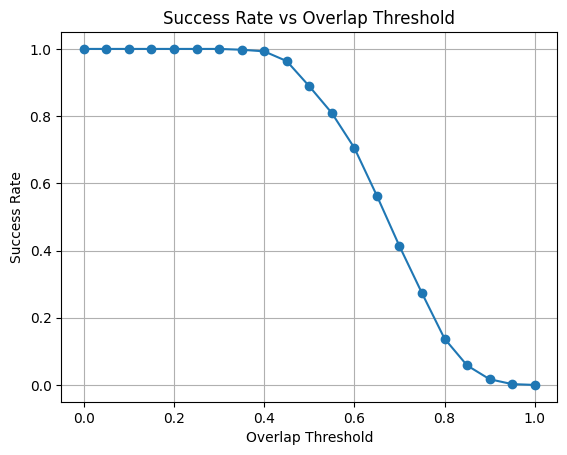

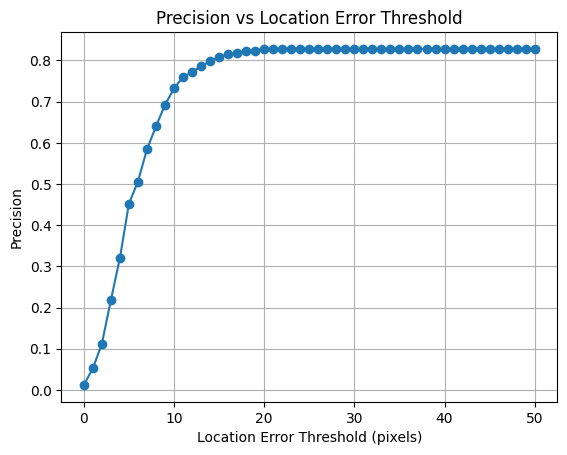

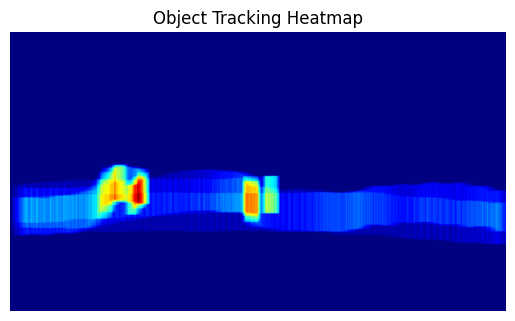

In [ ]:
def load_ground_truth(gt_file: str, target_object_id: int) -> Dict[int, Tuple[int, int, int, int]]:
    """
    Load ground truth data for a specific object ID.

    Args:
        gt_file (str): Path to the ground truth file.
        target_object_id (int): The object ID to track.

    Returns:
        Dict[int, Tuple[int, int, int, int]]: A dictionary mapping frame numbers to bounding boxes (x, y, w, h).
    """
    gt_data = {}
    with open(gt_file, 'r') as f:
        for line in f:
            parts = list(map(int, line.strip().split(',')))
            frame_number, object_id, x, y, w, h = parts[:6]
            if object_id == target_object_id:
                gt_data[frame_number] = (x, y, w, h)
    if not gt_data:
        raise ValueError(f"No ground truth available for object ID {target_object_id} in {gt_file}")
    return gt_data

def initialize_tracker(frame: np.ndarray, bbox: Tuple[int, int, int, int]) -> cv2.Tracker:
    """
    Initialize the CSRT tracker with a bounding box.

    Args:
        frame (np.ndarray): The initial frame.
        bbox (Tuple[int, int, int, int]): The bounding box (x, y, w, h).

    Returns:
        cv2.Tracker: The initialized tracker.
    """
    try:
        tracker = cv2.legacy.TrackerCSRT_create()
    except AttributeError:
        tracker = cv2.TrackerCSRT_create()
    tracker.init(frame, bbox)
    return tracker

def compute_iou(box1: Tuple[int, int, int, int], box2: Tuple[int, int, int, int]) -> float:
    """
    Compute Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (Tuple[int, int, int, int]): The first bounding box (x, y, w, h).
        box2 (Tuple[int, int, int, int]): The second bounding box (x, y, w, h).

    Returns:
        float: The IoU score.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def run_csrt_tracker(video_path: str, gt_file: str, output_video: str, target_object_id: int = 1) -> None:
    """
    Run a CSRT-based single-object tracker on a given video.

    Args:
        video_path (str): Path to the input video.
        gt_file (str): Path to the ground truth file.
        output_video (str): Path to save the output video.
        target_object_id (int): The object ID to track.
    """
    gt_data = load_ground_truth(gt_file, target_object_id)

    video_capture = cv2.VideoCapture(video_path)
    if not video_capture.isOpened():
        raise ValueError(f"Cannot open video file: {video_path}")

    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out_dir = os.path.dirname(output_video)
    os.makedirs(out_dir, exist_ok=True)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    tracker: Optional[cv2.Tracker] = None
    frame_times: List[float] = []
    iou_scores: List[float] = []
    center_errors: List[float] = []
    success_rates: List[List[int]] = []
    iou_thresholds = np.linspace(0, 1, 21)
    precision_thresholds = np.arange(0, 51, 1)
    precision_curve = np.zeros_like(precision_thresholds, dtype=float)
    heatmap = np.zeros((height, width), dtype=np.float32)

    frame_idx = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break

        frame_idx += 1
        if frame_idx in gt_data:
            gt_bbox = gt_data[frame_idx]
            x_gt, y_gt, w_gt, h_gt = gt_bbox

            if tracker is None:
                tracker = initialize_tracker(frame, gt_bbox)
            else:
                start_time = time.time()
                success, box = tracker.update(frame)
                frame_times.append(time.time() - start_time)

                if success:
                    x, y, w_box, h_box = map(int, box)
                    cv2.rectangle(frame, (x, y), (x + w_box, y + h_box), (255, 0, 0), 2)
                    cv2.rectangle(frame, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt), (0, 255, 0), 2)

                    iou = compute_iou((x, y, w_box, h_box), gt_bbox)
                    iou_scores.append(iou)
                    success_rates.append([1 if iou >= t else 0 for t in iou_thresholds])

                    center_pred = (x + w_box // 2, y + h_box // 2)
                    center_gt = (x_gt + w_gt // 2, y_gt + h_gt // 2)
                    center_error = np.linalg.norm(np.array(center_pred) - np.array(center_gt))
                    center_errors.append(center_error)

                    for i, threshold in enumerate(precision_thresholds):
                        if center_error <= threshold:
                            precision_curve[i] += 1

                    heatmap[y:y+h_box, x:x+w_box] += 1

        out.write(frame)

    video_capture.release()
    out.release()

    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_colored = cv2.applyColorMap(np.uint8(heatmap_norm), cv2.COLORMAP_JET)
    heatmap_output_path = os.path.join(out_dir, "heatmap.png")
    cv2.imwrite(heatmap_output_path, heatmap_colored)

    total_time = sum(frame_times)
    fps_speed = len(frame_times) / total_time if total_time > 0 else 0
    success_curve = np.mean(success_rates, axis=0) if success_rates else np.zeros_like(iou_thresholds)
    success_score = np.trapz(success_curve, iou_thresholds)
    precision_curve = precision_curve / frame_idx if frame_idx > 0 else precision_curve
    precision_score = precision_curve[20] * 100 if len(precision_curve) > 20 else 0

    print(f"Video saved at: {output_video}")
    print(f"Heatmap saved at: {heatmap_output_path}")
    print(f"Success Score: {success_score:.4f}")
    print(f"Precision Score (at 20px error): {precision_score:.2f}%")
    print(f"Tracking Speed: {fps_speed:.2f} FPS")

    plt.figure()
    plt.plot(iou_thresholds, success_curve, marker='o', linestyle='-')
    plt.xlabel("Overlap Threshold")
    plt.ylabel("Success Rate")
    plt.title("Success Rate vs Overlap Threshold")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(precision_thresholds, precision_curve, marker='o', linestyle='-')
    plt.xlabel("Location Error Threshold (pixels)")
    plt.ylabel("Precision")
    plt.title("Precision vs Location Error Threshold")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.imshow(cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Object Tracking Heatmap")
    plt.show()

def main():
    video_path = "/content/v_G-vNjfx1GGc_c600_video.mp4"
    gt_path = "/root/.cache/kagglehub/datasets/ayushspai/sportsmot/versions/1/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c600/gt/gt.txt"
    output_video_path = "/content/SOT_CSRT_output.mp4"

    run_csrt_tracker(video_path, gt_path, output_video_path, target_object_id=1)

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import files
files.download("/content/SOT_CSRT_output.mp4")